# Setup

In [1]:
WANDB_RUN_IDS = {
    (10, 30): 'bchkso4v',
    (75, 2): '1bcvpm0n',
    (150, 2): '2rs0ssve',
    (10, 15): 'c0c1e1rt',
    (20, 15): '2jfuxcqf',
    (5, 30): '1r2jaj79',
    (3, 50): '14jq4qss',
    (6, 50): 'hmjfqevi'
}

In [2]:
T = 6
N = 50

In [2]:
import jax
import jax.numpy as jnp              
import numpy as np                     
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xarray

from sol import *

In [4]:
config = {
    'data_dir': f'/data/akash/decay_turbulence_T{T}_N{N}/',
    'work_dir': './checkpoints/',
    'epochs': 100,
    'batch_size': 1,
    'learning_rate': 1e-4,
    'weight_decay': 0,
    'seed': 23,
    'dtype': jnp.float32,
    'solver_dtype': jnp.bfloat16,
    'timespan': N
}

@partial(jax.jit, static_argnums=2)
def predict(state, SP, timespan):
    pred = state.apply_fn({'params': state.params}, SP, timespan=timespan)
    return pred

def vorticity(ds):
    return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

def divergence(ds):
    return (ds.v.differentiate('y') + ds.u.differentiate('x')).rename('divergence')

def get_metrics(source, reference):
    err = reference - source
    MSE = (err**2).mean(axis=(1, 2))
    return err, MSE

try:
    assert(inner_steps == T)
    print("Solver inner steps checked")
except NameError:
    print("No solver")

Solver inner steps checked


# $\Delta$ Test

In [32]:
rng = jax.random.PRNGKey(config['seed'])
rng, init_rng = jax.random.split(rng)

state = create_train_state(
    init_rng, 
    config,
)

state = restore_checkpoint(state, config['work_dir']+WANDB_RUN_IDS[(T, N)])

In [33]:
SIM_NUM = 212
SIM = f'val/sim_{SIM_NUM}'

sp_files = sorted(glob(config['data_dir'] + f'SP/{SIM}/*.npy'))
SP = np.stack([np.load(f) for f in sp_files])

dp_files = sorted(glob(config['data_dir'] + f'DP/{SIM}/*.npy'))
DP = np.stack([np.load(f) for f in dp_files])

test_dataset = CFDDataset(config=config, train=False, sim=SIM)
test_loader = Data.DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=0, collate_fn=numpy_collate)

In [34]:
DP_shifted = DP[((SP.shape[-1]+2)//2 - 1):, :, :, :]
SP_shifted = SP[:(DP.shape[0] - (SP.shape[-1]+2)//2 + 1), :, :, -2:]

In [ ]:
preds = []

for i, (sp, dp) in enumerate(tqdm(test_loader)):
    preds.append(jax.device_get(predict(state, sp, timespan=config['timespan'])))
    
preds = np.concatenate(preds)
preds = preds.astype(np.float32)

err_d, MSE_d = get_metrics(SP_shifted, DP_shifted)
err_p, MSE_p = get_metrics(preds[:, -1, :], DP_shifted)

In [16]:
MSE_d = MSE_d.mean(axis=1)
MSE_p = MSE_p.mean(axis=1)

np.save(f'outputs/delta/MSEd_{T}_{N}_sim{SIM_NUM}.npy', MSE_d)
np.save(f'outputs/delta/MSEp_{T}_{N}_sim{SIM_NUM}.npy', MSE_p)

In [19]:
T = 6
N = 50
sim_nums = [211, 212]

MSE_d = np.mean([np.load(f'outputs/delta/MSEd_{T}_{N}_sim{sim_num}.npy') for sim_num in sim_nums], axis=0)
MSE_p = np.mean([np.load(f'outputs/delta/MSEp_{T}_{N}_sim{sim_num}.npy') for sim_num in sim_nums], axis=0)
    
print((MSE_d.mean() - MSE_p.mean()) / MSE_d.mean())

0.29286003

# Long run test

In [5]:
rng = jax.random.PRNGKey(config['seed'])
rng, init_rng = jax.random.split(rng)

state = create_train_state(
    init_rng, 
    config,
)

state = restore_checkpoint(state, config['work_dir']+WANDB_RUN_IDS[(T, N)])

In [22]:
SIM_NUM = 217
SIM = f'longtest/sim_{SIM_NUM}'

sp_files = sorted(glob(config['data_dir'] + f'SP/{SIM}/*.npy'))
SP_long = np.stack([np.load(f) for f in sp_files])

dp_files = sorted(glob(config['data_dir'] + f'DP/{SIM}/*.npy'))
DP_long = np.stack([np.load(f) for f in dp_files])

In [23]:
preds = []

sp = SP_long[0]
sp = jnp.expand_dims(sp, axis=0)

for i in tqdm(range(len(SP_long))):
    sp = predict(state, sp, timespan=1).squeeze(axis=0)
    preds.append(sp)
    
preds = jax.device_get(preds)
preds = np.squeeze(np.concatenate(preds))
preds = preds.astype(np.float32)

100%|██████████| 1000/1000 [00:04<00:00, 235.19it/s]


In [24]:
all_stacked = np.stack([SP_long, preds, DP_long])
ds_all = xarray.Dataset({
        'u': (('dtype', 'time', 'x', 'y'), all_stacked[:, :, :, :, 0]),
        'v': (('dtype', 'time', 'x', 'y'), all_stacked[:, :, :, :, 1]),
}, coords={'time': [inner_steps*t for t in range(all_stacked.shape[1])],
           'dtype': ['bfloat16', 'corrected', 'float64']
            })

In [47]:
err_d, MSE_d = get_metrics(SP_long[1:], DP_long[1:])
err_p, MSE_p = get_metrics(preds[:-1], DP_long[1:])

MSE_d = MSE_d.mean(axis=1)
MSE_p = MSE_p.mean(axis=1)

np.save(f'outputs/longrun/MSEd_{T}_{N}_sim{SIM_NUM}.npy', MSE_d)
np.save(f'outputs/longrun/MSEp_{T}_{N}_sim{SIM_NUM}.npy', MSE_p)

In [48]:
from jax_cfd.data.xarray_utils import isotropic_energy_spectrum

RANGE = 2000 // inner_steps
vorticity_all = ds_all.head(time=RANGE).thin(time=RANGE//5).pipe(vorticity)
vorticity_all.to_netcdf(f"outputs/longrun/vorticity_{T}_{N}_sim{SIM_NUM}.nc")

spectrum = isotropic_energy_spectrum(ds_all).mean('time')
spectrum.to_netcdf(f"outputs/longrun/spectrum_{T}_{N}_sim{SIM_NUM}.nc")

/home/btech/.conda/envs/ddp/lib/python3.8/site-packages/jax_cfd/data/xarray_utils.py:169: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xarray.apply_ufunc(


In [25]:
from jax_cfd.data import xarray_utils as xru

def correlation(x, y):
    state_dims = ['x', 'y']
    p  = xru.normalize(x, state_dims) * xru.normalize(y, state_dims)
    return p.sum(state_dims)

def calculate_time_until(vorticity_corr):
    threshold = 0.90
    return (vorticity_corr.mean('sample') >= threshold).idxmin('time').rename('time_until')

vel_mag = (ds_all.u**2 + ds_all.v**2)**0.5
vel_corr_ml = correlation(vel_mag.sel(dtype='float64').isel(time=slice(1, None)), vel_mag.sel(dtype='corrected').isel(time=slice(0, -1)))
vel_corr_16 = correlation(vel_mag.sel(dtype='float64').isel(time=slice(1, None)), vel_mag.sel(dtype='bfloat16').isel(time=slice(1, None)))
vel_corr = xarray.concat([vel_corr_ml, vel_corr_16], dim='dtype')
vel_corr = vel_corr.assign_coords({'dtype': ['corrected', 'bfloat16']})
vel_corr[dict(time=0)] = 1
vel_corr.to_netcdf(f"outputs/longrun/vel_corr_{T}_{N}_sim{SIM_NUM}.nc")

diverg_all = (ds_all.pipe(divergence)**2).mean(['x', 'y', 'time'])**0.5
diverg_all.to_netcdf(f"outputs/longrun/divergence_{T}_{N}_sim{SIM_NUM}.nc")

# Plots for paper

## Dataset Error Evolution

In [ ]:
MSE_hp = np.load('outputs/error_evolution/MSE_hp_init0.npy')
MSE_sp = np.load('outputs/error_evolution/MSE_sp_init0.npy')

plt.rcParams.update({'font.size': 14})
titles = ["float32 - float64", "bfloat16 - float64"]
fig, ax = plt.subplots(1, 1, figsize=(14,6))

ax.plot(MSE_sp.mean(axis=0))
ax.plot(MSE_hp.mean(axis=0))

for i in range(MSE_hp.shape[0]):
    ax.plot(MSE_sp[i], 'grey', alpha=0.2, linewidth=0.5)
    ax.plot(MSE_hp[i], 'grey', alpha=0.2, linewidth=0.5)
    
ax.set_ylabel("Mean Squared Error")
ax.legend(titles)
ax.set_xlabel("Timestep")
ax.grid()

# fig.savefig('outputs/dataset_evolution_error_init0.pdf', bbox_inches='tight')

## MSE Evolution

In [5]:
def calculate_limit(MSE_d, MSE_p, skip=0, percent=0.9):
    for i, (err_d, err_p) in enumerate(zip(MSE_d, MSE_p)):
        if i<skip:
            continue
        if err_p > percent*err_d:
            break
    return i

In [6]:
T = 6
N = 50
lims = []
sim_nums = [213, 214, 215, 216, 217]

for sim_num in sim_nums:
    MSE_d = np.load(f'outputs/longrun/MSEd_{T}_{N}_sim{sim_num}.npy')
    MSE_p = np.load(f'outputs/longrun/MSEp_{T}_{N}_sim{sim_num}.npy')
    skip = 0
    while True:
        lim = calculate_limit(MSE_d, MSE_p, skip=skip)
        if lim>4:
            break
        skip += 1
    lims.append(lim * T)
    
np.mean(lims)

1658.4

<ipython-input-7-3fdc69cc98c4>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(t*time) for time in axis.get_xticks()]);
<ipython-input-7-3fdc69cc98c4>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(t*time) for time in axis.get_xticks()]);
<ipython-input-7-3fdc69cc98c4>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(t*time) for time in axis.get_xticks()]);
<ipython-input-7-3fdc69cc98c4>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(t*time) for time in axis.get_xticks()]);
<ipython-input-7-3fdc69cc98c4>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels([int(t*time) for time in axis.get_xticks()]);
<ipython-input-7-3fdc69cc98c4>:24: UserWarning: FixedFormatter should only be used together with FixedLoc

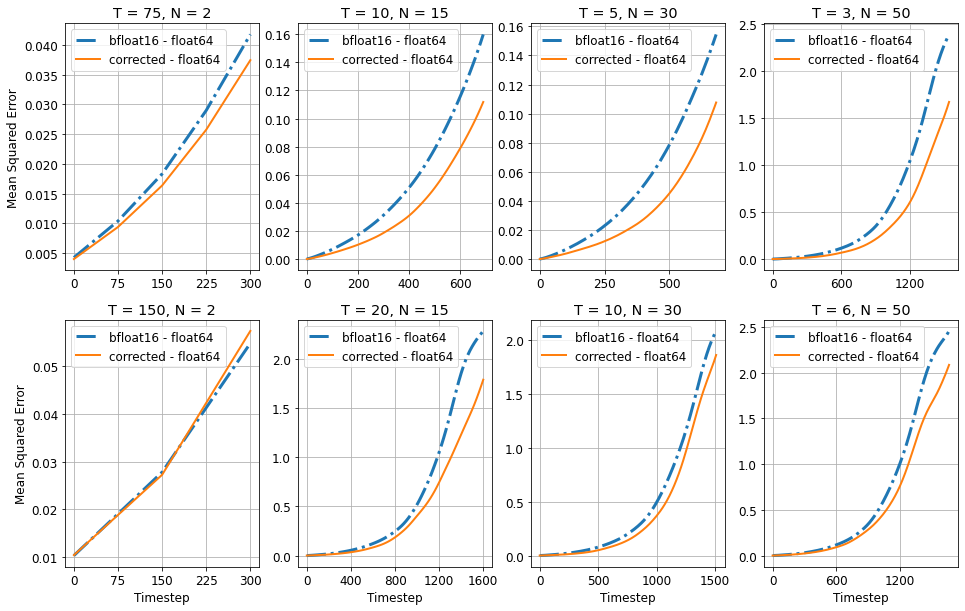

In [7]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(2, 4, figsize=(16,10))
ax = ax.flatten()
Ts = [75, 10, 5, 3, 150, 20, 10, 6]
Ns = [2, 15, 30, 50, 2, 15, 30, 50]
percents = [0.9, 0.7, 0.7, 0.7, 0.9, 0.8, 0.9, 0.85]
sim_nums = [213, 214, 215, 216, 217]

for t, n, percent, axis in zip(Ts, Ns, percents, ax):
    MSE_d = np.mean([np.load(f'outputs/longrun/MSEd_{t}_{n}_sim{sim_num}.npy') for sim_num in sim_nums], axis=0)
    MSE_p = np.mean([np.load(f'outputs/longrun/MSEp_{t}_{n}_sim{sim_num}.npy') for sim_num in sim_nums], axis=0)
    
    skip = 0
    while True:
        lim = calculate_limit(MSE_d, MSE_p, skip=skip, percent=percent)
        if lim>2:
            break
        skip += 1
        
    axis.plot(MSE_d[:lim], linestyle='-.', linewidth=3)
    axis.plot(MSE_p[:lim], linewidth=2)
    axis.legend(["bfloat16 - float64", "corrected - float64"])  
    axis.set_xticklabels([int(t*time) for time in axis.get_xticks()]);
    axis.grid()
    axis.set_title(f"T = {t}, N = {n}")
   
for i in [0, 4]:
    ax[i].set_ylabel("Mean Squared Error")
for i in [4, 5, 6, 7]:
    ax[i].set_xlabel("Timestep")
    
# fig.savefig("outputs/pred_error_evolution.pdf", bbox_inches="tight")

## Example visualization

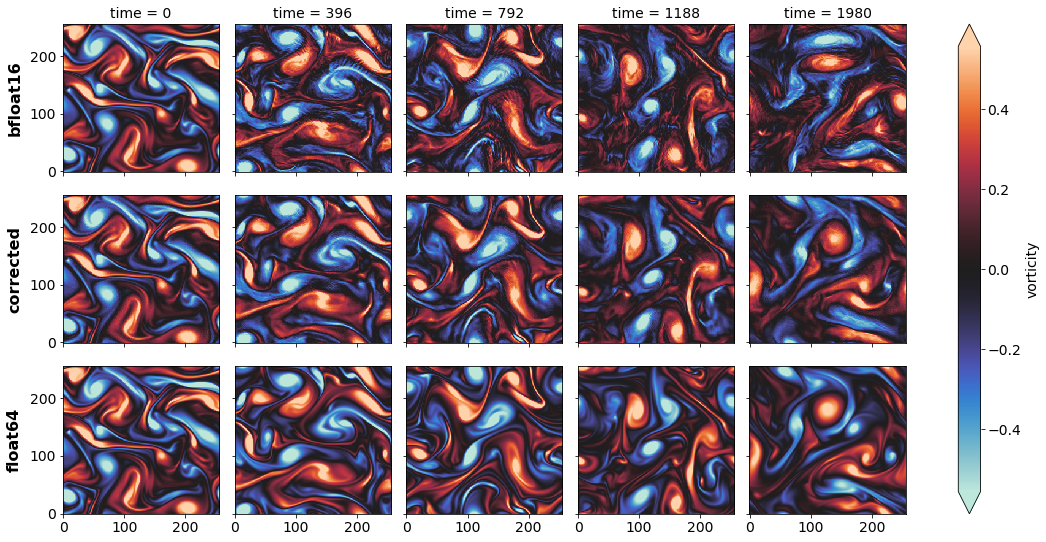

In [27]:
plt.rcParams.update({'font.size': 14})

vorticity_all = xarray.open_dataset(f"outputs/longrun/vorticity_{6}_{50}_sim{216}.nc").isel(time=[0,1,2,3,5])
grid = xarray.plot.imshow(vorticity_all.to_array().isel(variable=0),
                          row='dtype', 
                          col='time', 
                          cmap=seaborn.cm.icefire, 
                          robust=True,
                          figsize=(16,8),)

grid.row_labels[0].set_text('bfloat16')
grid.row_labels[1].set_text('corrected')
grid.row_labels[2].set_text('float64')
grid.cbar.set_label('vorticity')

for axis in grid.axes.flat:
    axis.set_ylabel(None)
    axis.set_xlabel(None)
    
for i in range(3):
    grid.row_labels[i].set_position((-4.75, 0.5))
    grid.row_labels[i].set_rotation(90)
    grid.row_labels[i].set_weight('bold')    
    grid.row_labels[i].set_fontsize(16)

# grid.fig.savefig('outputs/prediction_example.pdf', bbox_inches='tight', dpi=300)    

## Kinetic Energy spectrum

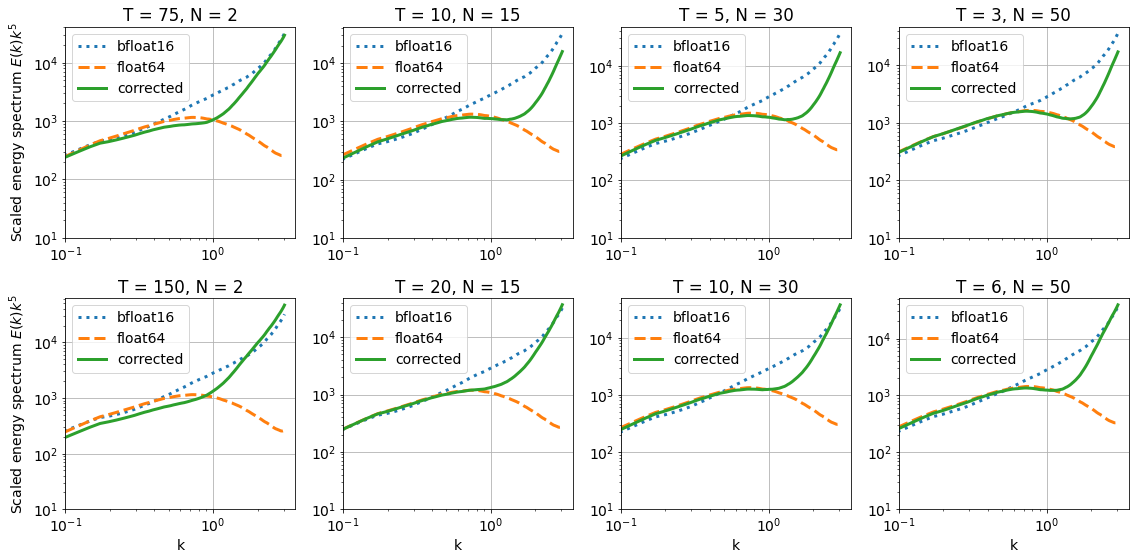

In [31]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(2, 4, figsize=(16,8))
ax = ax.flatten()
Ts = [75, 10, 5, 3, 150, 20, 10, 6]
Ns = [2, 15, 30, 50, 2, 15, 30, 50]
sim_nums = [213, 214, 215, 216, 217]

style_dict = {
    'float64': '--',
    'bfloat16': ':',
    'corrected': '-',
}
linewidth = 3

for t, n, axis in zip(Ts, Ns, ax):
    spectrum = xarray.concat([xarray.open_dataset(f"outputs/longrun/spectrum_{t}_{n}_sim{sim_num}.nc").to_array() for sim_num in sim_nums], dim='variable').mean('variable')
    scaled_spectrum = spectrum.k ** 5 * spectrum

    for label in ['bfloat16', 'float64', 'corrected']:
        scaled_spectrum.sel(dtype=label).rolling(k=7, center=True).mean().plot.line(label=label, ax=axis, linewidth=linewidth, linestyle=style_dict[label])

    axis.legend()
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.grid()
    axis.set_title(f'T = {t}, N = {n}')
    axis.set_xlim(0.1, None)
    axis.set_ylim(10, None)
    axis.set_xlabel('')

for i in [4, 5, 6, 7]:
    ax[i].set_xlabel("k")

for i in [0, 4]:
    ax[i].set_ylabel(r'Scaled energy spectrum $E(k) k^5$')

fig.tight_layout()
    
# fig.savefig("outputs/spectrum_comparison.pdf", bbox_inches="tight")

## Vorticity correlation and Divergence

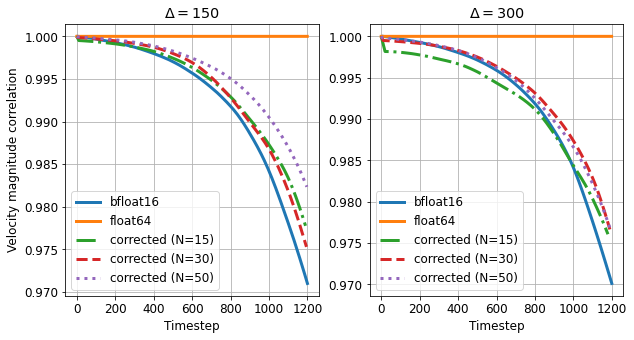

In [6]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax = ax.flatten()
params = {
    150: [(10, 15), (5, 30), (3, 50)],
    300: [(20, 15), (10, 30), (6, 50)]
}
sim_nums = [213, 214, 215, 216, 217]

style_dict = {
    15: '-.',
    30: '--',
    50: ':'
}
linewidth = 3
timelim = 1200

for i, (delta, tns) in enumerate(params.items()):
    vort_corr = xarray.concat([xarray.open_dataset(f"outputs/longrun/vel_corr_{tns[1][0]}_{tns[1][1]}_sim{sim_num}.nc").to_array() for sim_num in sim_nums], dim='variable').mean('variable')
    vort_corr = vort_corr.sel(time=slice(0, timelim))
    vort_corr.sel(dtype='bfloat16').plot.line(label='bfloat16', ax=ax[i], linewidth=linewidth)
    
    ax[i].plot([1]*timelim, label='float64', linewidth=linewidth)
    
    for t, n in tns:
        label = f"corrected (N={n})"
        vort_corr = xarray.concat([xarray.open_dataset(f"outputs/longrun/vel_corr_{t}_{n}_sim{sim_num}.nc").to_array() for sim_num in sim_nums], dim='variable').mean('variable')    
        
        vort_corr = vort_corr.sel(time=slice(0, timelim))
        vort_corr['time'] = vort_corr['time'] - vort_corr['time'][0]        

        vort_corr.sel(dtype='corrected').plot.line(label=label, ax=ax[i], linewidth=linewidth, linestyle=style_dict[n])
        
    ax[i].legend()
    ax[i].grid()
    ax[i].set_xlabel("Timestep")

ax[0].set_ylabel('Velocity magnitude correlation')
ax[0].set_title(r'$\Delta = 150$')
ax[1].set_title(r'$\Delta = 300$')
    
fig.savefig("outputs/velocity_correlation.pdf", bbox_inches="tight")

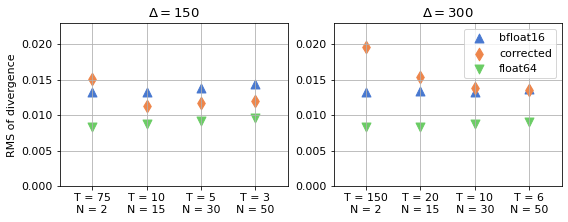

In [9]:
plt.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax = ax.flatten()

params = {
    150: [(75, 2), (10, 15), (5, 30), (3, 50)],
    300: [(150, 2), (20, 15), (10, 30), (6, 50)]
}
sim_nums = [213, 214, 215, 216, 217]

style_dict = {
    'bfloat16': {"marker": "^"},
    'float64': {"marker": "v"},
    'corrected': {"marker": "d"}
}

for i, (delta, tns) in enumerate(params.items()):
    tn_xlabels = [f"T = {t}\nN = {n}" for t, n in tns]
    div_vals = []
    legend = ['bfloat16', 'corrected', 'float64']
    
    for t, n in tns:
        diverg = xarray.concat([xarray.open_dataset(f"outputs/longrun/divergence_{t}_{n}_sim{sim_num}.nc").to_array() for sim_num in sim_nums], dim='variable').mean('variable')
        div_vals.append(list(diverg.values))
    div_vals = np.array(div_vals)
    
    ax[i].set_title(rf'$\Delta = {delta}$')
    ax[i].grid()
    ax[i].margins(x=0.2, y=0.2)   
    ax[i].set_ylim(0, 0.023)
    ax[i].set_prop_cycle(color=sns.color_palette("muted", 3))
    for j, label in enumerate(legend):
        ax[i].scatter(tn_xlabels, div_vals[:, j], label=label, **style_dict[label], s=80)

ax[1].legend()
ax[0].set_ylabel("RMS of divergence")

fig.savefig("outputs/divergence_reduction.pdf", bbox_inches="tight")